In [2]:
import tensorflow as tf

In [3]:
import requests
r = requests.get('http://api.ipify.org?format=json')
j = r.json()
print(j)

{'ip': '34.16.92.142'}


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess

from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Model

In [5]:
#Load in the data
fashion_mnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = x_train/255.0, x_test/255.0
print('x_train.shape:', x_train.shape)
print('x_train.shape:', x_train.shape)


4422102/4422102 [==============================] - 0s 0us/step
x_train.shape: (60000, 28, 28)
x_train.shape: (60000, 28, 28)


In [6]:
# data is only 2D
#convolution expects height x and width x dolor
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print(x_train.shape)

(60000, 28, 28, 1)


In [7]:
#no of classes
K = len(set(y_train))
print("number of classes:", K)

number of classes: 10


In [8]:
#Build the model using API
i = Input(shape=x_train[0].shape)
x = Conv2D(32,(3,3), strides=2, activation="relu")(i)
x = Conv2D(64,(3,3), strides=2, activation="relu")(x)
x = Conv2D(128,(3,3), strides=2, activation="relu")(x)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(512, activation = 'relu')(x)
x = Dropout(0.2)(x)
x = Dense(K, activation = 'softmax')(x)

model = Model(i,x)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 13, 13, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 6, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656

In [9]:
#Compile and fit

model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])
r = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs =15)

Epoch 1/15
1875/1875 [==============================] - 39s 19ms/step - loss: 0.5276 - accuracy: 0.8054 - val_loss: 0.4022 - val_accuracy: 0.8490
Epoch 2/15
1875/1875 [==============================] - 31s 17ms/step - loss: 0.3665 - accuracy: 0.8618 - val_loss: 0.3464 - val_accuracy: 0.8693
Epoch 3/15
1875/1875 [==============================] - 33s 18ms/step - loss: 0.3159 - accuracy: 0.8820 - val_loss: 0.3178 - val_accuracy: 0.8788
Epoch 4/15
1875/1875 [==============================] - 34s 18ms/step - loss: 0.2827 - accuracy: 0.8937 - val_loss: 0.3115 - val_accuracy: 0.8867
Epoch 5/15
1875/1875 [==============================] - 34s 18ms/step - loss: 0.2577 - accuracy: 0.9018 - val_loss: 0.3074 - val_accuracy: 0.8875
Epoch 6/15
1875/1875 [==============================] - 32s 17ms/step - loss: 0.2358 - accuracy: 0.9116 - val_loss: 0.3023 - val_accuracy: 0.8904
Epoch 7/15
1875/1875 [==============================] - 32s 17ms/step - loss: 0.2162 - accuracy: 0.9176 - val_loss: 0.2995 -

In [10]:
# save the model to a temporary directory
import tempfile

MODEL_DIR = tempfile.gettempdir()
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))
if os.path.isdir(export_path):
  print('\nAldready saved a model, cleaning up\n')
  !rm -r {export_path}

tf.saved_model.save(model, export_path)

print('\nSaved model:')
!ls -l {export_path}



export_path = /tmp/1


Saved model:
total 172
drwxr-xr-x 2 root root   4096 Apr 28 15:41 assets
-rw-r--r-- 1 root root     57 Apr 28 15:41 fingerprint.pb
-rw-r--r-- 1 root root 162075 Apr 28 15:41 saved_model.pb
drwxr-xr-x 2 root root   4096 Apr 28 15:41 variables


In [11]:
#details of export_path
!saved_model_cli show --dir {export_path} --all

2024-04-28 15:41:53.126944: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-28 15:41:53.127036: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-28 15:41:53.130492: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-28 15:41:54.770370: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the followin

In [12]:
#to get tensorflow serving api
!wget 'http://storage.googleapis.com/tensorflow-serving-apt/pool/tensorflow-model-server-2.8.0/t/tensorflow-model-server/tensorflow-model-server_2.8.0_all.deb'
!dpkg -i tensorflow-model-server_2.8.0_all.deb
!pip3 install tensorflow-serving-api==2.8.0

--2024-04-28 15:41:59--  http://storage.googleapis.com/tensorflow-serving-apt/pool/tensorflow-model-server-2.8.0/t/tensorflow-model-server/tensorflow-model-server_2.8.0_all.deb
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.124.207, 142.250.152.207, 142.250.128.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.124.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 340152790 (324M) [application/x-debian-package]
Saving to: ‘tensorflow-model-server_2.8.0_all.deb’

tensorflow-model-se 100%[===================>] 324.39M   157MB/s    in 2.1s    

2024-04-28 15:42:01 (157 MB/s) - ‘tensorflow-model-server_2.8.0_all.deb’ saved [340152790/340152790]

Selecting previously unselected package tensorflow-model-server.
(Reading database ... 121752 files and directories currently installed.)
Preparing to unpack tensorflow-model-server_2.8.0_all.deb ...
Unpacking tensorflow-model-server (2.8.0) ...
Setting up tensorflow-model-s

In [13]:
#assigning model dir to environment variable
os.environ["MODEL_DIR"] = MODEL_DIR

In [14]:
#start the tensorflow model server
#no hup-> not to shutdown server when logoff computer
#>server.log says that o/p of this program send to server .log

%%bash --bg
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=fashion_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

In [15]:
#last output of server.log
!tail server.log

In [16]:
#Label mapping
labels = '''T-shirt/top
Trouser
Pullover
Dress
Coat
Sandal
Shirt
Sneaker
Bag
Ankle Boot'''.split('\n')

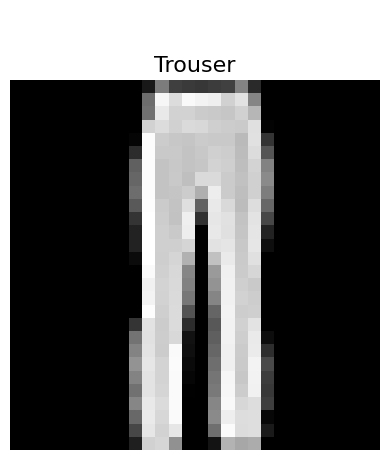

In [17]:
def show(idx, title):
  plt.figure()
  plt.imshow(x_test[idx],cmap='gray')
  plt.axis('off')
  plt.title('\n\n{}'.format(title), fontdict={'size': 16})

i = np.random.randint(0, len(x_test))
show(i, labels[y_test[i]])

In [41]:
#format some data to pass to the server

import json
data = json.dumps({'signature_name': 'serving_default', 'instances': x_test[0:3].tolist()})
print(data)

{"signature_name": "serving_default", "instances": [[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], 

In [19]:
headers = {"content-type": "application/json"}
r = requests.post('http://localhost:8501/v1/models/fashion_model:predict', data = data, headers = headers)
j = r.json()
print(j.keys())
print(j)

dict_keys(['predictions'])
{'predictions': [[9.53245322e-14, 8.20036452e-24, 1.59412236e-16, 5.13193626e-22, 1.30071425e-21, 6.54531776e-11, 3.44681943e-18, 2.99385256e-12, 1.44237272e-18, 1.0], [0.000167948951, 1.22310937e-11, 0.999825656, 4.22027885e-10, 1.91071445e-06, 1.89420188e-10, 4.48149694e-06, 8.82433051e-18, 5.49174699e-11, 2.48156769e-12], [2.33338739e-14, 1.0, 9.07922043e-18, 5.87957121e-16, 1.65844422e-12, 2.87905553e-27, 8.03472324e-19, 2.04372274e-34, 7.4635421e-20, 2.74130826e-28]]}


In [20]:
#changing the prediction values to array
pred = np.array(j['predictions'])
print(pred.shape)

(3, 10)


In [21]:
#get the predicted class
pred = pred.argmax(axis=1)

In [22]:
# map them bak to strings
pred = [labels[i] for i in pred]
print(pred)

['Ankle Boot', 'Pullover', 'Trouser']


In [23]:
# get the actual value
actual = [labels[i] for i in y_test[:3]]
print(actual)

['Ankle Boot', 'Pullover', 'Trouser']


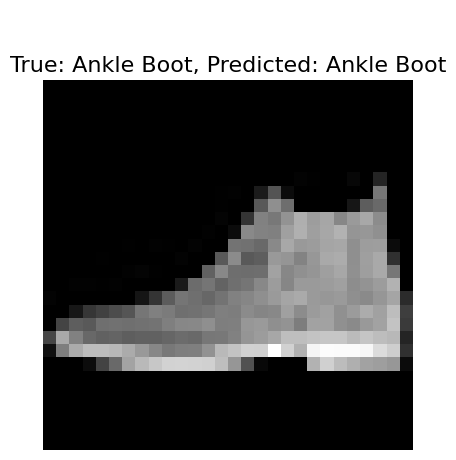

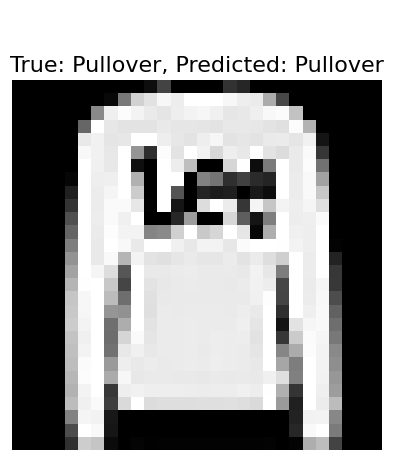

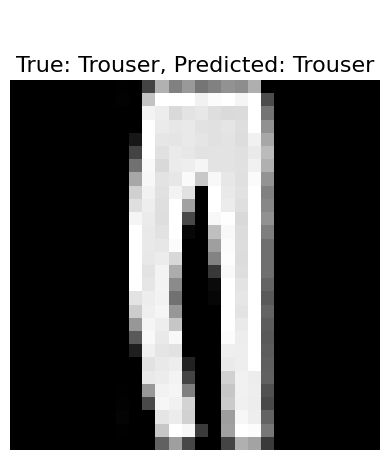

In [24]:
for i in range(0,3):
  show(i,f'True: {actual[i]}, Predicted: {pred[i]}')

In [42]:
# Allows you to select a model by version

headers = {"content-type": "application/json"}
j = requests.post('http://localhost:8501/v1/models/fashion_model/versions/1:predict', data=data, headers=headers)
j = r.json()
print(j.keys())

dict_keys(['predictions'])


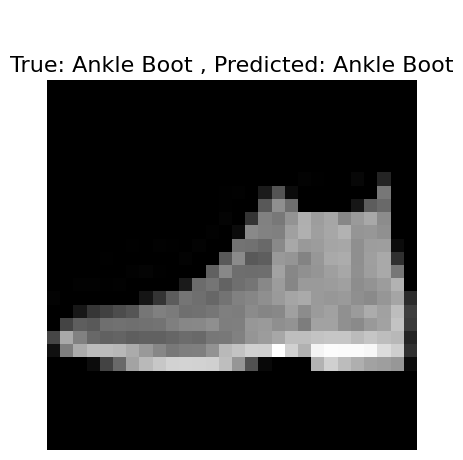

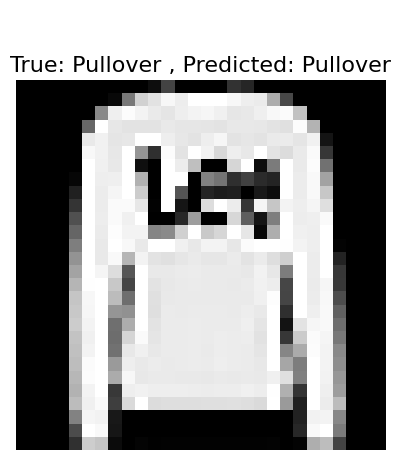

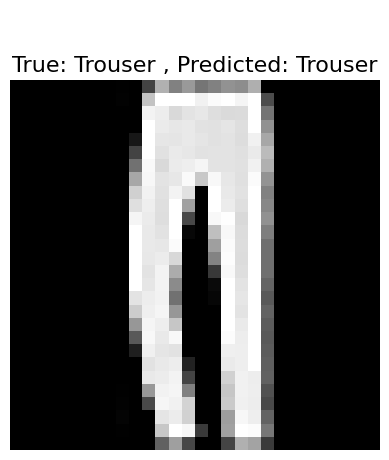

In [43]:
pred = np.array(j['predictions'])
pred = pred.argmax(axis=1)
pred =[labels[i] for i in pred]
for i in range(0,3):
  show(i, f"True: {actual[i]} , Predicted: {pred[i]}")

In [27]:
# lets make a new model version
i = Input(shape = x_train[0].shape)
x = Conv2D(32, (3, 3), strides = 2, activation = 'relu')(i)
x = Flatten()(x)
x = Dense(K, activation = 'softmax')(x)

model2 = Model(i, x)
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 32)        320       
                                                                 
 flatten_1 (Flatten)         (None, 5408)              0         
                                                                 
 dense_2 (Dense)             (None, 10)                54090     
                                                                 
Total params: 54410 (212.54 KB)
Trainable params: 54410 (212.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
#Compile and fit

model2.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])
r = model2.fit(x_train, y_train, validation_data = (x_test, y_test), epochs =15)

Epoch 1/15
1875/1875 [==============================] - 22s 11ms/step - loss: 0.4809 - accuracy: 0.8313 - val_loss: 0.4068 - val_accuracy: 0.8609
Epoch 2/15
1875/1875 [==============================] - 23s 12ms/step - loss: 0.3425 - accuracy: 0.8799 - val_loss: 0.3519 - val_accuracy: 0.8733
Epoch 3/15
1875/1875 [==============================] - 14s 7ms/step - loss: 0.3039 - accuracy: 0.8918 - val_loss: 0.3279 - val_accuracy: 0.8836
Epoch 4/15
1875/1875 [==============================] - 14s 7ms/step - loss: 0.2808 - accuracy: 0.9006 - val_loss: 0.3153 - val_accuracy: 0.8859
Epoch 5/15
1875/1875 [==============================] - 13s 7ms/step - loss: 0.2632 - accuracy: 0.9056 - val_loss: 0.3131 - val_accuracy: 0.8882
Epoch 6/15
1875/1875 [==============================] - 12s 6ms/step - loss: 0.2488 - accuracy: 0.9104 - val_loss: 0.3087 - val_accuracy: 0.8896
Epoch 7/15
1875/1875 [==============================] - 15s 8ms/step - loss: 0.2374 - accuracy: 0.9149 - val_loss: 0.3025 - val_

In [47]:
version = 2
export_path = os.path.join(MODEL_DIR, str(version))
print("export_path = {}\n".format(export_path))
if os.path.isdir(export_path):
  print('\n Aldready saved a model, cleaning up \n')
  !rm -r {export_path}

tf.saved_model.save(model2, export_path)
print('\nSaved model')
!ls -l {export_path}


export_path = /tmp/2


 Aldready saved a model, cleaning up 


Saved model
total 88
drwxr-xr-x 2 root root  4096 Apr 28 16:31 assets
-rw-r--r-- 1 root root    57 Apr 28 16:31 fingerprint.pb
-rw-r--r-- 1 root root 76550 Apr 28 16:31 saved_model.pb
drwxr-xr-x 2 root root  4096 Apr 28 16:31 variables


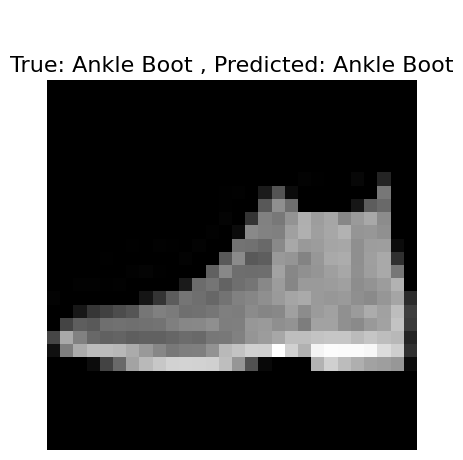

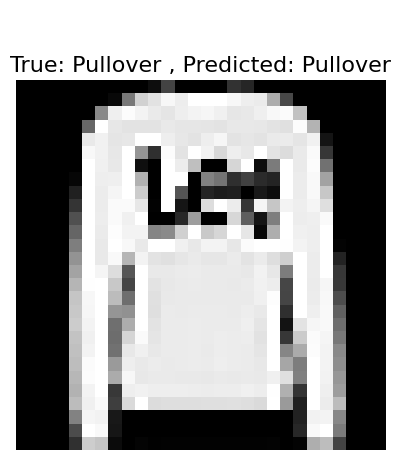

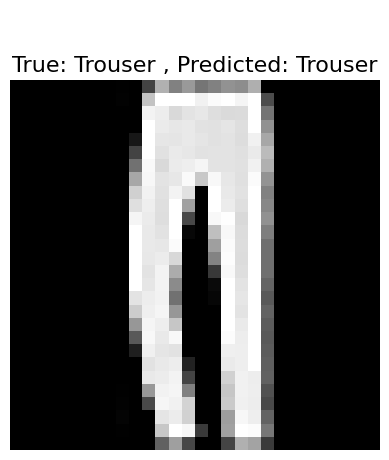

In [48]:
headers = {'content-type': 'application/json'}
r = requests.post('http://localhost:8501/v1/models/fashion_model/versions/2:predict', data=data, headers=headers)
j = r.json()
pred = np.array(j['predictions'])
pred = pred.argmax(axis=1)
pred =[labels[i] for i in pred]
for i in range(0,3):
  show(i, f"True: {actual[i]} , Predicted: {pred[i]}")

In [49]:
headers = {'content-type': 'application/json'}
r = requests.post('http://localhost:8501/v1/models/fashion_model/versions/3:predict', data=data, headers=headers)
j = r.json()
print(j)

{'error': 'Servable not found for request: Specific(fashion_model, 3)'}
